# Introduction


In this project, I implement image-to-image translation from human selfies to anime faces using CycleGan.

In [3]:
# Imports
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import random
import matplotlib.pyplot as plt


## Data Preparation / Loading

In this section I create dataloaders for the real and anime selfies. I also pre-process the data by resizing each image to be 128 x 128 in order to reduce computation time.

In [12]:
# Hyperparameters for the Loaders
BATCH_SIZE = 1
NUM_WORKERS = 2

# Resize each image to be 128 x 128 and transform it into a pytorch tensor
transformations = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()]
)

# Creating training, testing, and validation datasets for both real faces and anime faces
realFacesTrain = torchvision.datasets.ImageFolder(root="./data/trainA", transform=transformations)
realFacesTrain, realFacesVal = random_split(realFacesTrain, [int(0.9 * len(realFacesTrain)), int(0.1 * len(realFacesTrain))])
realFacesTest = torchvision.datasets.ImageFolder(root="./data/testA", transform=transformations)

animeFacesTrain = torchvision.datasets.ImageFolder(root="./data/trainB", transform=transformations)
animeFacesTrain, animeFacesVal = random_split(animeFacesTrain, [int(0.9 * len(animeFacesTrain)), int(0.1 * len(animeFacesTrain))])
animeFacesTest = torchvision.datasets.ImageFolder(root="./data/testB", transform=transformations)

# Creating loaders for the training, testing, and validation datasets for both real faces and anime faces
realFacesTrainLoader = torch.utils.data.DataLoader(realFacesTrain,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
realFacesTestLoader = torch.utils.data.DataLoader(realFacesTest,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
realFacesValLoader = torch.utils.data.DataLoader(realFacesVal,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)

animeFacesTrainLoader = torch.utils.data.DataLoader(animeFacesTrain,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
animeFacesTestLoader = torch.utils.data.DataLoader(animeFacesTest,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
animeFacesValLoader = torch.utils.data.DataLoader(animeFacesVal,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)

# Visualization of Dataset

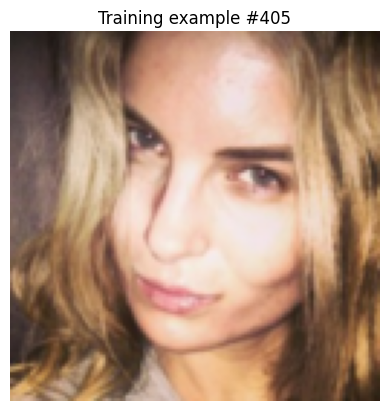

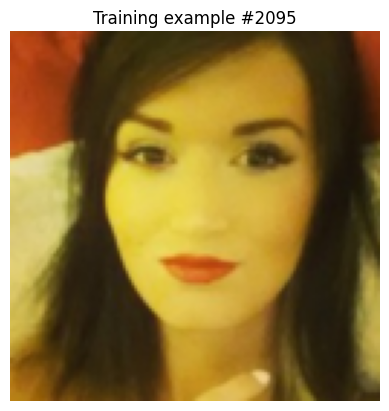

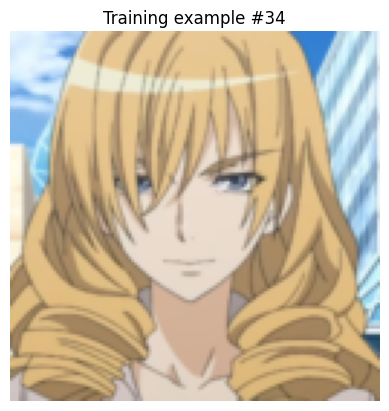

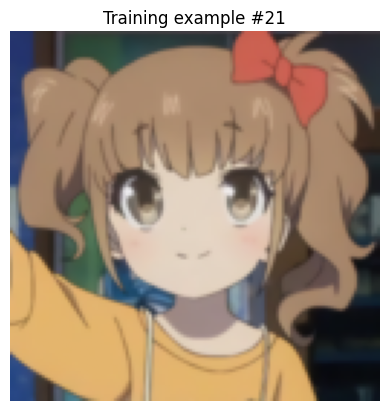

In [17]:
# Visualize a couple of images from the anime and face datasets
def visualize_samples(dataset, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(dataset))
        img, _ = dataset[random_seg_img]
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
visualize_samples(realFacesTrain, 2)
visualize_samples(animeFacesTest, 2)



# Constructing the Generative Model

In [10]:
# Generative Model
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock).__init__()
        self.num_channels = num_channels
        self.single_residual_block = nn.Sequential(
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU(),
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU() # This could optionally be taken away?
        )
    def forward(self, x):
        return x + self.single_residual_block(x)

class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        # Downsampling layers
        self.downSampleLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect"),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels = 256, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        # At the end of downsampling, input is 32x32x256

        # 6 residual blocks, as recommended in the paper for 128 x 128 images
        self.residualLayers = nn.Sequential( # maybe should be module list?
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsampling layers
        self.upSampleLayers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 1, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 1, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )
        # At the end of upsampling layers input is 128x128x64

        # Final layer, reverts back to 3 color channels. Output is 128x128x3
        self.out = nn.Conv2d(64, 3, 7, 1, 3, padding_mode= "reflect")

    def forward(self, x):
        x = self.downSampleLayers(x)
        x = self.residualLayers(x)
        x = self.upSampleLayers(x)
        x = self.out(x)
        return x
        

# Constructing the Discriminator Model

In [11]:
# Discriminative Model
# Generative Model

class DiscriminativeModel(nn.Module):
    def __init__(self):
        super(DiscriminativeModel, self).__init__()
        
        # Discriminator Layers
        self.discriminatorLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            # No instance norm for the first layer, as the cycleGan paper suggests
            nn.LeakyReLU(0.2),
            # Output is 64x64x64

            nn.Conv2d(in_channels =64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            # Output is 32x32x128

            nn.Conv2d(in_channels =128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            # Output is 16x16x256

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            # Output is 8x8x512
        )

        self.out = nn.Sequential(
            nn.Conv2d(512, 1, 4,1,1, padding_mode="reflect"),
            nn.Sigmoid() 
        )
        # Results in a binary label

    def forward(self, x):
        x = self.discriminatorLayers(x)
        x = self.out(x)
        return x

# Training

In [22]:
# Training
def train(realFaceLoader, animeFaceLoader, genRealModel, genAnimeModel, discRealModel, discAnimeModel, genOpt, discOpt, epochs=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
  #  model = model.to(device)

    for e in range(3):
  #      model.train()
        for idx, (realFace, _) in enumerate(realFaceLoader):
            animeFace = next(iter(animeFaceLoader))
            if idx % 100 == 0:
                plt.imshow(realFace.permute(1, 2, 0))
                plt.axis('off')
                plt.show()
                plt.imshow(animeFace.permute(1, 2, 0))
                plt.axis('off')
                plt.show()
            # realFace = realFace.to(device)
            # animeFace = animeFace.to(device)
train(realFacesTrainLoader, animeFacesTrainLoader, 5, 3, 4, 4, 3, 3)


cpu


KeyboardInterrupt: 

# Visualizing Results

In [ ]:
# Code to visualize results